# Digit Classification from MNIST Dataset.

Creating a feed forward neural network for digit classification from the famous MNIST dataset. Also adding GPU support.

In [11]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [12]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

# hyperparameters
input_size = 784  # mnist has 28x28 images, which after flattening becomes 784
hidden_size = 1000 # number of nodes in hidden layer
NUM_CLASSES = 10
EPOCHS = 10
BATCH_SIZE = 32 # Yann LeCun said mini batch size of more than 32 shouldn't be used.
LR = 0.001

In [13]:
# Importing MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True, transform=transforms.ToTensor())

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                           download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
# Looking at shapes of samples and labels in a single batch.
examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


We can see from the shape that our samples has a shape of 32x1x28x28, 32 being the batch size. We also see that our labels are in a 1-D array.

We may need to first flatten our samples into an array of 32x784.

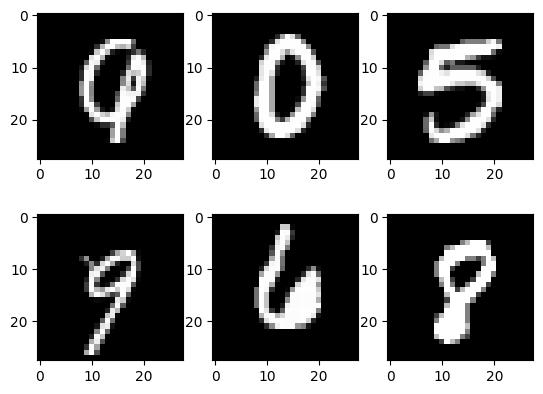

In [15]:
# Plotting the first 6 images in batch 1.
for i in range(6):
  plt.subplot(2, 3, i+1)  # creating a grid with 2 rows and 3 cols
  plt.imshow(samples[i][0], cmap='gray')  # plotting images with color map = gray
  plt.show;  # display

In [16]:
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, num_classes)
    )

  def forward(self, x):
    out = self.layer_stack(x)
    return out

model = NeuralNet(input_size, hidden_size, NUM_CLASSES).to(device)

We're not using softmax here at the output layer. This is because our loss function will be `nn.CrossEntropyLoss()`, which expects the predictions as logits. So applying softmax manually would be doing it twice, which makes training slow.

In [17]:
# loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LR)

In [18]:
### Training Loop
total_batches = len(train_loader)
for epoch in range(EPOCHS):
  for batch, (images, labels) in enumerate(train_loader):
    # Getting all the images in the batch
    images = images.reshape(-1, 28*28).to(device) # We can either do this, or we can use the flatten layer in the model.
    labels = labels.to(device)

    # forward pass
    outputs = model(images)
    loss = loss_fn(outputs, labels)

    # backward pass
    optimizer.zero_grad() # setting the gradients to zero
    loss.backward() # backpropagation
    optimizer.step()  # optimizing our parameters

    if (batch+1)%100 == 0:
      print(f'Epoch: {epoch+1}/{EPOCHS} | Batch: {batch+1}/{total_batches} | Train Loss: {loss.item():.5f}')

Epoch: 1/10 | Batch: 100/1875 | Train Loss: 0.13666
Epoch: 1/10 | Batch: 200/1875 | Train Loss: 0.12523
Epoch: 1/10 | Batch: 300/1875 | Train Loss: 0.39583
Epoch: 1/10 | Batch: 400/1875 | Train Loss: 0.23039
Epoch: 1/10 | Batch: 500/1875 | Train Loss: 0.13093
Epoch: 1/10 | Batch: 600/1875 | Train Loss: 0.11467
Epoch: 1/10 | Batch: 700/1875 | Train Loss: 0.34180
Epoch: 1/10 | Batch: 800/1875 | Train Loss: 0.05690
Epoch: 1/10 | Batch: 900/1875 | Train Loss: 0.30829
Epoch: 1/10 | Batch: 1000/1875 | Train Loss: 0.03326
Epoch: 1/10 | Batch: 1100/1875 | Train Loss: 0.11187
Epoch: 1/10 | Batch: 1200/1875 | Train Loss: 0.17992
Epoch: 1/10 | Batch: 1300/1875 | Train Loss: 0.00757
Epoch: 1/10 | Batch: 1400/1875 | Train Loss: 0.44022
Epoch: 1/10 | Batch: 1500/1875 | Train Loss: 0.10371
Epoch: 1/10 | Batch: 1600/1875 | Train Loss: 0.01951
Epoch: 1/10 | Batch: 1700/1875 | Train Loss: 0.23654
Epoch: 1/10 | Batch: 1800/1875 | Train Loss: 0.08888
Epoch: 2/10 | Batch: 100/1875 | Train Loss: 0.02164
Epo

In [19]:
### Testing Loop
model.eval()
with torch.inference_mode():
  n_correct = 0
  n_samples = 0

  for images, labels in test_loader:
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)
    outputs = model(images)
    # returns value, index. We only need index i.e the class label
    _, predictions = torch.max(outputs, dim=1)  # returns the index having the highest value.
    n_samples += labels.shape[0]  # Gives us number of samples in current batch (should be 32)
    n_correct += torch.eq(predictions, labels).sum().item() # adding 1 for every correct prediction.

  acc = 100 * n_correct / n_samples
  print(f'accuracy = {acc}')

accuracy = 98.09
